<a href="https://colab.research.google.com/github/KimSoEun/pythonforai/blob/main/experiments/BiLSTM_review_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Colab에 Mecab 설치

In [1]:
# # Colab에 Mecab 설치
# !git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
# %cd Mecab-ko-for-Google-Colab
# !bash install_macab-ko_on_colab190912.sh

위의 예제처럼 했더니 Mecab 설치에 실패했다. 구글링 해서 나온 다음 코드로 바꿔보자.

참고 링크: [참고한 티스토리 블로그](https://biology-statistics-programming.tistory.com/32)

In [2]:
# !apt-get update
# !apt-get install g++ openjdk-8-jdk
# !pip install konlpy JPype1-py3
# !bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

위에서 참고한 설치방법에도 문제가 생겨, GPT가 알려준 대로 해보겠음.
## 1) 시스템 라이브러리 설치
- `libmecab-dev` : Python 바인딩 컴파일에 필요한 헤더 파일
- `mecab-ipadic-utf8` : 일본어 기본 사전(한국어 코퍼스용은 차후 추가)

In [3]:
!apt-get update
!apt-get install -y g++ openjdk-8-jdk libmecab-dev mecab mecab-ipadic-utf8

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 3,632 B in 4s (864 B/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Don

> 참고: `apt-get install mecab-ko mecab-ko-dic` 대신 `mecab-ipadic-utf8`를 먼저 설치하고, Python 패키지로 KO‐DICT를 지정하는 방법이 훨씬 안정적입니다.

## 2) Python용 Mecab 패키지 설치
기존 `mecab-python` 패키지는 업데이트가 더디고, 종종 `egg_info` 에러가 발생합니다. 대신 활발히 유지보수 중인 `mecab-python3` 를 설치하세요.

In [4]:
!pip install mecab-python3


- 이 패키지는 pip만으로 설치가 가능하며, 내부적으로 이미 `libmecab-dev`를 잘 참조합니다.

## 3) 한국어 사전 (mecab-ko-dic) 설치
한국어 형태소 분석용으로 `mecab-ko-dic`을 깔아야 합니다. 아래처럼 GitHub 릴리즈에서 직접 내려받아 설치하세요.

In [5]:
# (1) 최신 버전 압축 풀기
!curl -L https://bitbucket.org/eunjeon/mecab-ko-dic/downloads/mecab-ko-dic-2.1.1-20180720.tar.gz | tar xz

# (2) 빌드 및 설치
%cd mecab-ko-dic-2.1.1-20180720
!./autogen.sh
!./configure --with-charset=utf8
!make
!make install

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 47.4M  100 47.4M    0     0  8880k      0  0:00:05  0:00:05 --:--:-- 11.5M
/content/mecab-ko-dic-2.1.1-20180720
Looking in current directory for macros.
configure.ac:2: warning: AM_INIT_AUTOMAKE: two- and three-arguments forms are deprecated.
./lib/autoconf/general.m4:2434: AC_DIAGNOSE is expanded from...
aclocal.m4:139: AM_INIT_AUTOMAKE is expanded from...
configure.ac:2: the top level
configure.ac:56: warning: AC_OUTPUT should be used without arguments.
configure.ac:56: You should run autoupdate.
configure.ac:2: warning: AM_INIT_AUTOMAKE: two- and three-arguments forms are deprecated.  For more info, see:
configure.ac:2: https://www.gnu.org/software/automake/manual/automake.html#Modernize-AM_005fINIT_005fAUTOMAKE-invocation
checking for a BSD-comp

> Tip: `configure` 단계에서 `--with-charset=utf8` 을 꼭 지정해야, Python에서 UTF-8 인코딩으로 문제 없어요.

## 4) `/usr/local/etc/mecabrc` 설정 변경
설치가 끝나면 시스템 설정 파일에 새로운 사전 경로를 지정해 줍니다.

In [6]:
!sed -i 's|^dicdir.*|dicdir = /usr/local/lib/mecab/dic/mecab-ko-dic|' /usr/local/etc/mecabrc

- 이 한 줄로 `dicdir`을 자동으로 덮어써 줍니다.

## 5) 동작 확인
Colab 노트북에서 간단히 테스트해 보세요.

정상 설치 되었다면, 형태소 분석 결과가 출력됩니다.

In [7]:
import MeCab

# Tagger 객체 생성
tagger = MeCab.Tagger()

# parse() 대신 parse 메서드 호출
result = tagger.parse("안녕하세요. 저는 ChatGPT입니다.")
print(result)


안녕	NNG,행위,T,안녕,*,*,*,*
하	XSV,*,F,하,*,*,*,*
세요	EP+EF,*,F,세요,Inflect,EP,EF,시/EP/*+어요/EF/*
.	SF,*,*,*,*,*,*,*
저	NP,*,F,저,*,*,*,*
는	JX,*,T,는,*,*,*,*
ChatGPT	SL,*,*,*,*,*,*,*
입니다	VCP+EF,*,F,입니다,Inflect,VCP,EF,이/VCP/*+ᄇ니다/EF/*
.	SF,*,*,*,*,*,*,*
EOS



---
# 2. 스팀 리뷰 데이터에 대한 이해와 전처리

In [30]:
import pandas as pd
import numpy as np
import urllib.request
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import  Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [29]:
from konlpy.tag import Mecab

In [36]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px


## 1) 데이터 로드하기

In [9]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/steam.txt", filename='steam.txt')

('steam.txt', <http.client.HTTPMessage at 0x79443751a250>)

In [10]:
total_data = pd.read_table('steam.txt', names=['label', 'reviews'])
print('전체 리뷰 개수 :', len(total_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 100000


In [11]:
total_data[:5]

,label,reviews
0,0,노래가 너무 적음
1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다."
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요


* 리뷰와 라벨의 중복을 제외한 갯수 보기

In [12]:
total_data['reviews'].nunique(), total_data['label'].nunique()

(99892, 2)

- NULL값 유무 확인하기

In [13]:
print(total_data.isnull().values.any())

False


## 2) 훈련 데이터와 테스트 데이터 분리하기

In [14]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수: ', len(train_data))
print('테스트용 리뷰의 개수: ', len(test_data))

훈련용 리뷰의 개수:  75000
테스트용 리뷰의 개수:  25000


## 3) 레이블의 분포 확인

<Axes: xlabel='label'>

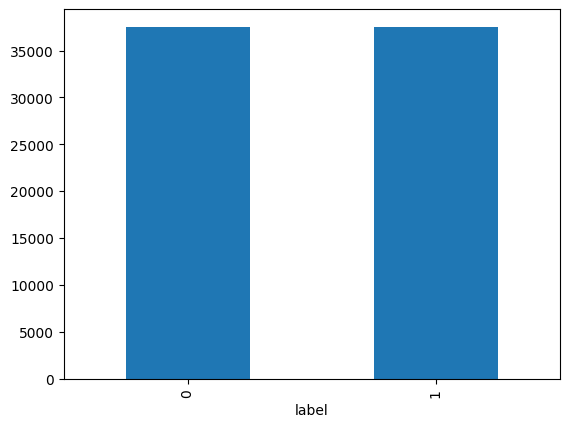

In [15]:
train_data['label'].value_counts().plot(kind = 'bar')

In [16]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  37522
1      1  37478


## 4) 데이터 정제하기
정규 표현식을 사용하여 한글을 제외하고 모두 제거해줍니다. 또한 혹시 이 과정에서 빈 샘플이 생기지는 않는지 확인합니다.

In [17]:
# 한글과 공백을 재외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-하-ㅣ가-힣]", "", regex=True) # 정규 표현식 수행
train_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
print(train_data.isnull().sum()) # null 값 몇 개 남았는지 확인, 없을 것임

label      0
reviews    0
dtype: int64


/tmp/ipython-input-17-1940184514.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경


테스트 데이터도 똑같은 작업을 해주자.

In [18]:
# 데이터셋 나누기 전에 중복 처리 했다고 안 하고 돌리니까 개수 그대로 나옴. 해주면 데이터 4개 없어짐.
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-하-ㅣ가-힣]", "", regex=True) # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 : ', len(test_data))

전처리 후 테스트용 샘플의 개수 :  24996


/tmp/ipython-input-18-934362035.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경


불용어를 정의해줍니다.

In [19]:
stopwords = ['도','는','다','의','가','이','은','한','에','하','고','을','를','인','듯','과','와','네','들','듯','지','임','게','만','게임','겜','되','음','면']

## 5) 토큰화
형태소 분석기 Mecab을 사용하여 토큰화 작업을 수행합니다.

In [21]:
mecab = Mecab()

train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

## 6) 단어와 길이 분포 확인하기
긍정 리뷰에는 주로 어떤 단어들이 많이 등장하고, 부정 리뷰에는 주로 어떤 단어들이 등장하는지 두 가지 경우에 대해서 각 단어의 빈도수를 계산해보겠습니다. 각 레이블에 따라서 별도로 단어들의 리스트를 저장해줍니다.

In [22]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

Counter()를 사용하여 각 단어에 대한 빈도수를 카운트합니다. 우선 부정 리뷰에 대해서 빈도수가 높은 상위 20개 단어들을 출력합니다.

In [24]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[(np.str_('안'), 7830), (np.str_('없'), 6801), (np.str_('있'), 5663), (np.str_('는데'), 5568), (np.str_('같'), 4076), (np.str_('로'), 4059), (np.str_('할'), 3812), (np.str_('거'), 3586), (np.str_('해'), 3559), (np.str_('나'), 3489), (np.str_('너무'), 3409), (np.str_('으로'), 3288), (np.str_('기'), 3211), (np.str_('했'), 3179), (np.str_('어'), 3171), (np.str_('습니다'), 2989), (np.str_('지만'), 2931), (np.str_('좋'), 2852), (np.str_('것'), 2843), (np.str_('겠'), 2801)]


긍정 리뷰에 대해서도 동일하게 출력해봅시다.

In [25]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[(np.str_('있'), 9668), (np.str_('좋'), 6252), (np.str_('습니다'), 5038), (np.str_('할'), 4783), (np.str_('지만'), 4750), (np.str_('재밌'), 4702), (np.str_('해'), 4256), (np.str_('없'), 4075), (np.str_('로'), 3860), (np.str_('으로'), 3792), (np.str_('보'), 3782), (np.str_('수'), 3776), (np.str_('는데'), 3609), (np.str_('기'), 3481), (np.str_('것'), 3320), (np.str_('같'), 3281), (np.str_('안'), 3230), (np.str_('어'), 3073), (np.str_('네요'), 3022), (np.str_('나'), 2936)]


두 가지 경우에 대해서 각각 길이 분포를 확인해봅시다.

In [108]:
# import plotly.io as pio
# pio.templates.default = 'plotly_white'   # 혹은 'plotly'

fig = make_subplots(rows=1, cols=2, subplot_titles=['Positive 긍정 댓글','Negative 부정 댓글'])
for i, lbl in enumerate([1,0], start=1):
    lengths = train_data[train_data['label']==lbl]['tokenized'].map(len)
    counts = lengths.value_counts().sort_index()
    fig.add_trace(
       go.Bar(
         x=counts.index,
         y=counts.values,
         name = 'Positives' if lbl==1 else 'Negatives',
         marker=dict(color='green' if lbl==1 else 'indianred', opacity=1.0)
       ),
       row=1, col=i
    )

fig.update_layout(
    # template='plotly_white',
    xaxis_title='Token Length 댓글 길이',
    yaxis_title='Count 댓글에 포함된 총 단어 개수',
    showlegend=False
)
fig.show()

In [81]:
train_data.head(10)

,label,reviews,tokenized
98980,1,최종도망칠때초간침실에서도망친뒤갑자기속도가빨라질때방에서나가면의자가많은방에서따라오던몹이...,"[최종, 망칠, 때, 초간, 침실, 에서, 망친, 뒤, 갑자기, 속도, 빨라질, 때..."
69824,1,오크보스만날때입닥치게하는내면살생각있음네메시스로하고있는데대사외워지겠네,"[오크, 보스, 만날, 때, 입, 닥치, 내면, 살, 생각, 있, 네메시스, 로, ..."
9928,1,비연시비둘기연애시뮬레이터걍겜인줄알았지만갓-겜이라놀랐음흥미롭네공략깨갈때마다놀라운게임,"[비, 연시, 비둘기, 연애, 시뮬레이터, 걍겜인줄알았지만갓, -, 라, 놀, 랐음..."
75599,0,시발돈안벌린다고게임옆에있는게임으로만들어버리네ㅋㅋㅋㅋㅋ게임사람정말많아지겠습니다ㅋㅋㅋ,"[시발, 돈, 안, 벌린다고, 옆, 있, 으로, 만들, 어, 버리, ㅋㅋㅋ, ㅋㅋ,..."
95621,0,군대다녀와도정식출시가안돼있는게임곰신도못기다릴듯이건고무신거꾸로신어도인정임,"[군대, 다녀와도, 정식, 출시, 안, 돼, 있, 곰, 신, 못, 기다릴, 이건, ..."
80724,1,아매우재밌읍니다으로영화편본그런느낌이네요이런겜더나왔으면좋겠읍니다,"[아, 매우, 재밌, 읍니다, 으로, 영화, 편, 본, 그런, 느낌, 네요, 이런,..."
78925,0,게임자체는잘만들어져재미있으나고질적인서버불안정으로인한로그인불가팅김렉등네트워크문제로반복...,"[자체, 잘, 만들, 어, 져, 재미있, 으나, 고질, 적, 서버, 불, 안정, 으..."
14672,0,내가생각했던미연시게임이아니다아마도버전제로라서그런가레알분이면은엔딩봄,"[내, 생각, 했, 던, 미, 연시, 아니, 아마도, 버전, 제로, 라서, 그런, ..."
76016,1,원소를확실이배운다물산소불돌점,"[원소, 확실이, 배운, 다물, 산소, 불돌, 점]"
95628,1,기대햇던만큼재미있습니다,"[기대, 햇, 던, 만큼, 재미있, 습니다]"


In [77]:
pstv_len = train_data[train_data['label'] == 1]['tokenized'].map(lambda x: len(x))
ngtv_len = train_data[train_data['label'] == 0]['tokenized'].map(lambda x: len(x))
print('긍정 리뷰의 평균 길이 : ', np.mean(pstv_len))
print('부정 리뷰의 평균 길이 : ', np.mean(ngtv_len))

긍정 리뷰의 평균 길이 :  14.664736645498692
부정 리뷰의 평균 길이 :  14.859202601140664


유의미한 차이가 있는 것 같진 않습니다.

---

In [78]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test = test_data['tokenized'].values
y_test = test_data['label'].values

## 7) 정수 인코딩
기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩을 수행해야 합니다.

우선, 훈련 데이터에 대해서 집합(vocabulary)을 만들어 봅시다.

In [80]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

단어 집합이 생성되는 동시에 각 단어에 고유한 정슈가 부여되었습니다. 이는 tokenizer.word_index를 출력하여 확인 가능합니다. 등장 횟수가 1회인 단어들은 자연어 처리에서 배제하고자 합니다. 이 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해봅시다.

In [87]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
  total_freq += value

  # 단어의 등장 빈도수가 threshold보다 작으면!
  if(value < threshold):
    rare_cnt += 1
    rare_freq += value

print('단어 집합(vocabulary)의 크기 : ', total_cnt)
print(f'등장 빈도가 {threshold-1}번 뿐인 희귀 단어의 수 : {rare_cnt}')
print('단어 집합에서 희귀 단어의 비율 : ', 100*rare_cnt/total_cnt)
print('전체 등장 빈도에서 희귀 단어 등장 빈도 비율 : ', 100*rare_freq/total_freq)

단어 집합(vocabulary)의 크기 :  40063
등장 빈도가 1번 뿐인 희귀 단어의 수 : 19655
단어 집합에서 희귀 단어의 비율 :  49.06023013753339
전체 등장 빈도에서 희귀 단어 등장 빈도 비율 :  1.7752756622396926


단어가 약 40,000개가 존재합니다. 1번만 등장하는 단어들은 단어 집합에서 약 49%를 차지합니다. 하지만, 실제로 훈련 데이터에서 등장하는 빈도는 약 1.8%로 매우 적습니다. 아무래도 이 단어들은 따로 처리하기엔 별로 중요하지 않아 보입니다. 그래서 이 단어들은 정수 인코딩 과정에서 제외하겠습니다.등장 빈도수가 1인 단어들의 수를 제외한 단어의 개수를 단어 집합의 최대 크기로 제한하겠습니다.

In [88]:
# 전체 단어 개수 중 빈도수가 1인 단어 개수는 제거.
# 0번째 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 : ', vocab_size)

단어 집합의 크기 :  20410


단어 집합의 크기는 20,410입니다. 이를 Tokenizer의 인자로 넘겨주면, Tokenizer는 텍스트 시퀀스를 숫자 시퀀스로 변환합니다. 이러한 정수 인코딩 과정에서 이보다 큰 숫자가 부여된 단어들은 OOV(out of vocabulary)로 변환하겠습니다.




In [91]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

정수 인코딩이 진행되었는지 확인하고자 X_train과 X_test에 대해 상위 3개의 샘플만 출력합니다.

In [100]:
for i in range(3):
  print(X_train[i])

[2386, 7967, 34, 15301, 10773, 32, 5369, 410, 468, 592, 1, 34, 539, 32, 501, 4565, 60, 539, 32, 4412, 75, 828, 930, 1070, 18, 4412, 228, 77, 2]
[1978, 364, 3319, 34, 980, 3158, 8648, 207, 52, 2, 8649, 9, 2, 5, 1362, 7968, 31]
[193, 2198, 6931, 4020, 935, 1, 79, 53, 958, 1]


In [101]:
for i in range(3):
  print(X_test[i])

[2823, 445, 632, 4816, 7427, 49, 2531, 990]
[48, 59, 17, 12, 98, 201, 362, 555, 20, 153, 74, 1080, 1086, 165, 73, 18, 25, 1, 20, 12, 30, 41, 213, 7, 17, 547, 1317, 54, 61, 6, 54, 121, 2214, 2557, 81, 137, 72, 31, 503, 28, 2557, 670, 3, 305, 278, 83, 48, 1015, 391]
[49, 498, 32, 3333, 1787]


## 8) 패딩
서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 패딩 작업을 진행해보겠습니다. 전체 데이터에서 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포를 알아보겠습니다.

In [115]:
# 리뷰 길이 계산
lengths = [len(review) for review in X_train]

# Plotly 히스토그램
fig = px.histogram(
    x = lengths,
    nbins = 50,
    labels = {'x': 'length of samples', 'y': 'number of samples'},
    title = '리뷰 길이 분포'
)

# 레이아웃 세부 조정
fig.update_layout(
    xaxis_title = '샘플 길이',
    yaxis_title = '샘플 갯수'
)

fig.show()

# 통계 출력
print(f'리뷰의 최대 길이 : {max(lengths)}')
print(f'리뷰의 평균 길이 : {sum(lengths)/len(lengths):.2f}')

리뷰의 최대 길이 : 63
리뷰의 평균 길이 : 14.76


리뷰의 최대 길이는 63, 평균 길이는 약 15입낟. 그래프로 봤을 때, 전체적으로는 60 이하의 길이를 가지는 것으로 보입니다.

In [116]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
      count += 1
  print(f'전체 샘플 중 길이가 {max_len} 이하인 샘플의 비율 : {100*count / len(nested_list)}')

최대 길이가 63이므로 만약 60으로 패딩할 경우, 몇 개의 샘플들을 온전이 보전할 수 있는지 확인합니다.

In [117]:
max_len = 60
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 60 이하인 샘플의 비율 : 99.99333333333334


훈련용 리뷰의 99.99%가 60 이하의 길이를 가집니다. 훈련용 리뷰를 길이 60으로 패딩하겠습니다.

In [118]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

# 4. BiLSTM으로 스팀 리뷰 감성 분류하기
LSTM이 Bidirectional() 안에 기재되었다는 사실에 주목!

In [121]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units))) # Bidirectional LSTM을 사용
model.add(Dense(1, activation = 'sigmoid'))

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)
mc = ModelCheckpoint('best_model.h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True)

model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)

Epoch 1/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - acc: 0.5795 - loss: 0.6659
Epoch 1: val_acc improved from -inf to 0.74720, saving model to best_model.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 170s 701ms/step - acc: 0.5797 - loss: 0.6657 - val_acc: 0.7472 - val_loss: 0.5170
Epoch 2/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - acc: 0.7589 - loss: 0.4969
Epoch 2: val_acc improved from 0.74720 to 0.77547, saving model to best_model.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 160s 679ms/step - acc: 0.7590 - loss: 0.4969 - val_acc: 0.7755 - val_loss: 0.4874
Epoch 3/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - acc: 0.7906 - loss: 0.4540
Epoch 3: val_acc improved from 0.77547 to 0.78093, saving model to best_model.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 201s 675ms/step - acc: 0.7906 - loss: 0.4540 - val_acc: 0.7809 - val_loss: 0.4697
Epoch 4/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - acc: 0.8063 - loss: 0.4317
Epoch 4: val_acc improved from 0.78093 to 0.78207, saving model to best_model.h5


235/235 ━━━━━━━━━━━━━━━━━━━━ 202s 675ms/step - acc: 0.8062 - loss: 0.4317 - val_acc: 0.7821 - val_loss: 0.4662
Epoch 5/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - acc: 0.8139 - loss: 0.4151
Epoch 5: val_acc did not improve from 0.78207
235/235 ━━━━━━━━━━━━━━━━━━━━ 203s 678ms/step - acc: 0.8139 - loss: 0.4151 - val_acc: 0.7779 - val_loss: 0.4770
Epoch 6/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 618ms/step - acc: 0.8255 - loss: 0.3937
Epoch 6: val_acc did not improve from 0.78207
235/235 ━━━━━━━━━━━━━━━━━━━━ 166s 706ms/step - acc: 0.8255 - loss: 0.3937 - val_acc: 0.7802 - val_loss: 0.4839
Epoch 7/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - acc: 0.8383 - loss: 0.3761
Epoch 7: val_acc did not improve from 0.78207
235/235 ━━━━━━━━━━━━━━━━━━━━ 158s 673ms/step - acc: 0.8383 - loss: 0.3761 - val_acc: 0.7762 - val_loss: 0.4789
Epoch 8/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - acc: 0.8440 - loss: 0.3632
Epoch 8: val_acc did not improve from 0.78207
235/235 ━━━━━━━━━━━━━━━━━━━━ 166s 709ms/

에포크 8에서 조기 종료가 발생했습니다.

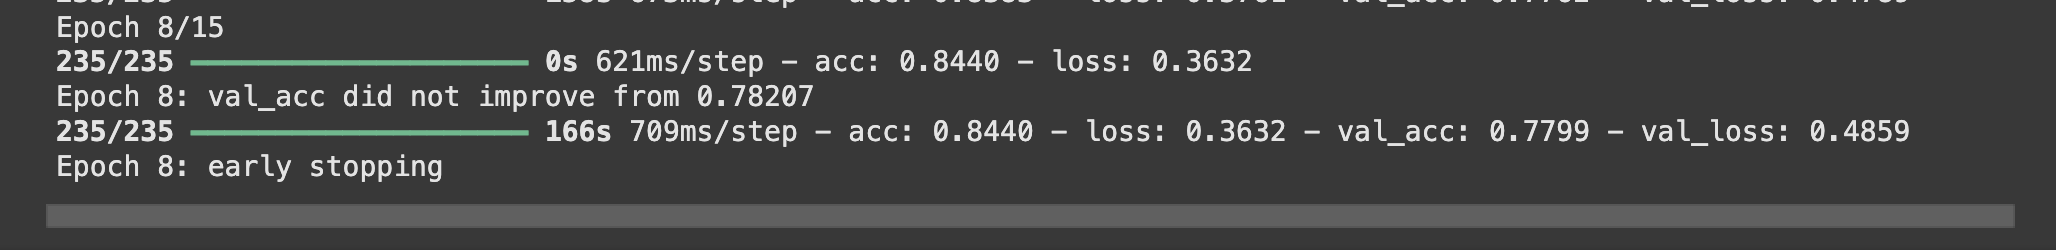

In [122]:
loaded_model = load_model('best_model.h5')
print(f'테스트 정확도: {loaded_model.evaluate(X_test, y_test)[1]:.4f}')

782/782 ━━━━━━━━━━━━━━━━━━━━ 43s 54ms/step - acc: 0.7742 - loss: 0.4774
테스트 정확도: 0.7761


테스트 정확도 약 78%

# 5. 리뷰 예측해보기
임의의 문장에 대한 예측을 위해서는 학습하기 전 전처리를 동일하게 적용해줍니다.

In [124]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-하-ㅣ가-힣]', '', new_sentence)
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new))
  if(score > 0.5):
    print(f'{score*100:.2f}% 확률로 긍정 리뷰입니다.')
  else:
    print(f'{(1-score)*100:.2f}% 확률로 부정 리뷰입니다.')

In [125]:
sentiment_predict('콘텐츠가 별로 없는 듯.. 한 500시간 정도 되면 질리기 시작함.. 근데 질렸다는 건 아님 이건 농장 힐링? 아니 농장 도파민 게임이다.')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
66.28% 확률로 부정 리뷰입니다.


/tmp/ipython-input-124-1684509914.py:7: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



In [126]:
sentiment_predict('새벽까지도 졸아가면서도 했던 게임. 혼자해본적은 없음. 친구들이랑 노가리 까면서 하기에도 좋음. 뉴비들은 애인 한 명 골라서 호감작 + 낚시 하면서 시간 보내다보면 재미 찾아갈거임.')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
83.35% 확률로 긍정 리뷰입니다.


/tmp/ipython-input-124-1684509914.py:7: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



In [127]:
sentiment_predict('딱 하루만 더 해야지.. 딱 하루만 더 해야지.. 딱 하루만 더 해야지... 무한굴레에 빠지게 되는 게임')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
64.44% 확률로 부정 리뷰입니다.


/tmp/ipython-input-124-1684509914.py:7: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



In [128]:
sentiment_predict('할인할 때 꼭 사야할 게임 1순위!!!! 진짜 재밌어요 혼자해도 개꿀잼ㅎㅎ')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
98.32% 확률로 긍정 리뷰입니다.


/tmp/ipython-input-124-1684509914.py:7: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



In [129]:
sentiment_predict('싫어요')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
66.55% 확률로 부정 리뷰입니다.


/tmp/ipython-input-124-1684509914.py:7: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



In [130]:
sentiment_predict('꿀잼')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
95.95% 확률로 긍정 리뷰입니다.


/tmp/ipython-input-124-1684509914.py:7: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

